In [ ]:
#hide
import sys
if 'google.colab' in sys.modules:
    !pip install -Uqq fastai einops datasets axial_positional_embedding
    !pip install -qq git+git://github.com/arampacha/reformer_fastai.git

     |████████████████████████████████| 194kB 10.0MB/s 
     |████████████████████████████████| 163kB 10.3MB/s 
     |████████████████████████████████| 61kB 8.7MB/s 
     |████████████████████████████████| 17.7MB 206kB/s 
     |████████████████████████████████| 245kB 59.6MB/s 


In [ ]:
#hide
%load_ext autoreload
%autoreload 2

In [ ]:
#all_slow

# enwik8 - baseline

In [ ]:
from fastai.text.all import *

from reformer_fastai.tokenizers import ByteTextTokenizer
from reformer_fastai.transformer import TransformerLM
from reformer_fastai.data import read_and_prepare_data, read_lines
from reformer_fastai.metrics import BPC
from reformer_fastai.optimizers import adafactor

## Experiment Tracking

Make sure you have wandb and are logged in:

In [ ]:
#hide
!pip install -Uqq wandb
!wandb login

     |████████████████████████████████| 1.8MB 7.3MB/s 
     |████████████████████████████████| 133kB 16.8MB/s 
     |████████████████████████████████| 81kB 10.9MB/s 
     |████████████████████████████████| 102kB 13.5MB/s 
     |████████████████████████████████| 163kB 25.8MB/s 
     |████████████████████████████████| 71kB 11.2MB/s 
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Load Experiment Tracking with Weights & Biases:

In [ ]:
import wandb
from fastai.callback.wandb import *

WANDB_NAME = 'enc_lm_enwik8_base_af'
GROUP = 'TEST'
NOTES = 'Baseline Transformer LM on enwik8 sl 1024'
CONFIG = {}
TAGS =['lm','test','enwik8']

Initialise wandb logging, pleaes **do not change** `project` or `entity` (that that everything gets logged to the same place)

In [ ]:
# wandb.init(reinit=True, project="reformer-fastai", entity="fastai_community", 
#            name=WANDB_NAME, group=GROUP, notes=NOTES,  tags=TAGS) # config=CONFIG,

## Download and Unpack enwik8 Data

Download and unzip enwik8 data

In [ ]:
#hide_output
!wget -P data/ http://mattmahoney.net/dc/enwik8.zip
!unzip data/enwik8.zip -d data/
!ls data
!head -n 10 data/enwik8

--2021-01-02 20:25:37--  http://mattmahoney.net/dc/enwik8.zip
Resolving mattmahoney.net (mattmahoney.net)... 67.195.197.24
Connecting to mattmahoney.net (mattmahoney.net)|67.195.197.24|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 36445475 (35M) [application/zip]
Saving to: ‘data/enwik8.zip’

enwik8.zip          100%[===================>]  34.76M   908KB/s    in 40s     

2021-01-02 20:26:17 (898 KB/s) - ‘data/enwik8.zip’ saved [36445475/36445475]

Archive:  data/enwik8.zip
  inflating: data/enwik8             
enwik8	enwik8.zip
<mediawiki xmlns="http://www.mediawiki.org/xml/export-0.3/" xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" xsi:schemaLocation="http://www.mediawiki.org/xml/export-0.3/ http://www.mediawiki.org/xml/export-0.3.xsd" version="0.3" xml:lang="en">
  <siteinfo>
    <sitename>Wikipedia</sitename>
    <base>http://en.wikipedia.org/wiki/Main_Page</base>
    <generator>MediaWiki 1.6alpha</generator>
    <case>first-letter</case>
      <na

## Prepare Data

In [ ]:
df = pd.DataFrame({'text':read_lines('/content/data/enwik8')})
df.head()

,text
0,"<mediawiki xmlns=""http://www.mediawiki.org/xml/export-0.3/"" xmlns:xsi=""http://www.w3.org/2001/XMLSchema-instance"" xsi:schemaLocation=""http://www.mediawiki.org/xml/export-0.3/ http://www.mediawiki.org/xml/export-0.3.xsd"" version=""0.3"" xml:lang=""en"">\n"
1,<siteinfo>\n
2,<sitename>Wikipedia</sitename>\n
3,<base>http://en.wikipedia.org/wiki/Main_Page</base>\n
4,<generator>MediaWiki 1.6alpha</generator>\n


In [ ]:
btt = ByteTextTokenizer(is_lm=True, add_bos=False, add_eos=False)

In [ ]:
%%time
df['toks'] = df['text'].apply(btt)
df['lens'] = df['toks'].apply(len)
df['lens_cum_sum'] = df.lens.cumsum()

CPU times: user 2min 2s, sys: 4.4 s, total: 2min 6s
Wall time: 1min 59s


In [ ]:
train_cutoff = df.lens.sum() - 10_000_000  # keep all but 10M characters for val and test
train_idxs = df.loc[df['lens_cum_sum'] < train_cutoff].index.values
train_idxs = list(range(0, max(train_idxs)))

remaining_idxs = len(df) - max(train_idxs)
validation_idxs = list(range(max(train_idxs), max(train_idxs) + int(remaining_idxs/2)))
test_idxs = list(range(max(validation_idxs), len(df)))

splits = [train_idxs, validation_idxs]

In [ ]:
#hide
@patch
def create_item(self:LMDataLoader, seq):
    if seq>=self.n: raise IndexError
    sl = self.last_len if seq//self.bs==self.n_batches-1 else self.seq_len
    st = (seq%self.bs)*self.bl + (seq//self.bs)*self.seq_len
    txt = self.chunks[st : st+sl+1]    
    return LMTensorText(txt[:-1]),txt[1:]

In [ ]:
%%time
tfms = [attrgetter("text"), btt]
dsets = Datasets(df, [tfms], splits=splits, dl_type=LMDataLoader)

CPU times: user 1.08 s, sys: 51.2 ms, total: 1.13 s
Wall time: 1.13 s


In [ ]:
%%time
bs, sl = 8, 1024
# pad_seq2seq = partial(pad_input, pad_idx=bte.pad_token_id, pad_fields=[0,1])
dl_kwargs = [{'lens':df['lens'].values[train_idxs]},
             {'val_lens':df['lens'].values[validation_idxs]}]
dls = dsets.dataloaders(bs=bs, seq_len=sl, dl_kwargs=dl_kwargs, shuffle_train=True, n_workers=2)

CPU times: user 28 s, sys: 1.91 s, total: 30 s
Wall time: 35.4 s


In [ ]:
#collapse_output
dls.show_batch(max_n=4)

,text,text_
0,"\n <timestamp>2002-02-25T15:51:15Z</timestamp>\n[[hi:प्लेग]]\nSee also: the discussion of [[race and intelligence]].\n </revision>\nSome variants of Bangla, particularly Chittagonian and Chakma Bangla (considered by some to be separate languages), have contrastive [[tone (linguistics)|tone]]; differences in the pitch of the speaker's voice can distinguish words.\n{{commons|Haliaeetus leucocephalus}}\n0% (1999 est.)\n <id>10238</id>\n*1969 - [[Ari Meyers]], Puerto Rican-born American actress\n\n[[fi:Herakleios]]\n*Henry Hase 1807-1829\n <username>Yaohua2000</username>\n\n\n[[zh:骨骼]]</text>\n*[[1936]] - The [[United Auto Workers]] (UAW) gains autonomy from the [[American Federation of Labor]].\n|100 TB = 90.9 TiB\n*[[1950]] - [[Dan Seals]], American singer\n\n\n\n*[http://www.ranchcardoso.biz An AQH @ a California Bloodless Bullfight]\n* Ballistic wire printers (discussed in the [[dot matrix printer]]s article)\n\n* Militarized police forces and private security forces\n\n | author=Siljander, Pauli\n{{listde","<timestamp>2002-02-25T15:51:15Z</timestamp>\n[[hi:प्लेग]]\nSee also: the discussion of [[race and intelligence]].\n </revision>\nSome variants of Bangla, particularly Chittagonian and Chakma Bangla (considered by some to be separate languages), have contrastive [[tone (linguistics)|tone]]; differences in the pitch of the speaker's voice can distinguish words.\n{{commons|Haliaeetus leucocephalus}}\n0% (1999 est.)\n <id>10238</id>\n*1969 - [[Ari Meyers]], Puerto Rican-born American actress\n\n[[fi:Herakleios]]\n*Henry Hase 1807-1829\n <username>Yaohua2000</username>\n\n\n[[zh:骨骼]]</text>\n*[[1936]] - The [[United Auto Workers]] (UAW) gains autonomy from the [[American Federation of Labor]].\n|100 TB = 90.9 TiB\n*[[1950]] - [[Dan Seals]], American singer\n\n\n\n*[http://www.ranchcardoso.biz An AQH @ a California Bloodless Bullfight]\n* Ballistic wire printers (discussed in the [[dot matrix printer]]s article)\n\n* Militarized police forces and private security forces\n\n | author=Siljander, Pauli\n{{listdev"
1,"had retired from Kabul when the [[United Kingdom|British]] armies entered Afghanistan. The Russian governor-general at [[Tashkent]] sent for Abdur Rahman, and pressed him to try his fortunes once more across the Oxus. In March [[1880]] a report reached India that Abdur Rahman was in northern Afghanistan; and the governor-general, [[Robert Bulwer-Lytton, 1st Earl of Lytton|Lord Lytton]], opened communications with him to the effect that the British government were prepared to withdraw their troops, and to recognize Abdur Rahman as ''amir'' of Afghanistan, with the exception of Kandahar and some districts adjacent to it. After some negotiations, an interview took place between him and [[Lepel Griffin]], the diplomatic representative at Kabul of the [[India]]n government. Griffin described Abdur Rahman as a man of middle height, with an exceedingly intelligent face and frank and courteous manners, shrewd and able in conversation on the business in hand.\n# [[Berlin]] with 3,391,407 inhabitants \n[[nl:Glossolalie]","had retired from Kabul when the [[United Kingdom|British]] armies entered Afghanistan. The Russian governor-general at [[Tashkent]] sent for Abdur Rahman, and pressed him to try his fortunes once more across the Oxus. In March [[1880]] a report reached India that Abdur Rahman was in northern Afghanistan; and the governor-general, [[Robert Bulwer-Lytton, 1st Earl of Lytton|Lord Lytton]], opened communications with him to the effect that the British government were prepared to withdraw their troops, and to recognize Abdur Rahman as ''amir'' of Afghanistan, with the exception of Kandahar and some districts adjacent to it. After some negotiations, an interview took place between him and [[Lepel Griffin]], the diplomatic representative at Kabul of the [[India]]n government. Griffin described Abdur Rahman as a man of middle height, with an exceedingly intelligent face and frank and courteous manners, s

In [ ]:
vocab_sz = btt.vocab_size

In [ ]:
#hide
df.drop(columns='toks', inplace=True, )
df.to_csv('enwik8.csv')

In [ ]:
xb, yb = dls.one_batch()
xb.shape, yb.shape

((8, 1024), (8, 1024))

In [ ]:
#hide
del xb, yb
torch.cuda.empty_cache()

## Training

In [ ]:
#hide_output
wandb.init(reinit=True, project="reformer-fastai", entity="fastai_community", 
           name=WANDB_NAME, group=GROUP, notes=NOTES, tags=TAGS, config=CONFIG)

wandb: Currently logged in as: fastai_community (use `wandb login --relogin` to force relogin)


In [ ]:
# opt_func = partial(adafactor, warmup_init=True)
opt_func = adafactor

learn = Learner(dls, TransformerLM(vocab_sz, 1024, n_layers=3, max_seq_len=sl),
                loss_func=CrossEntropyLossFlat(), opt_func=opt_func,
                metrics=[accuracy, perplexity, BPC()]).to_native_fp16()

SuggestedLRs(lr_min=1.8214517331216486e-05, lr_steep=0.00017626078624743968)

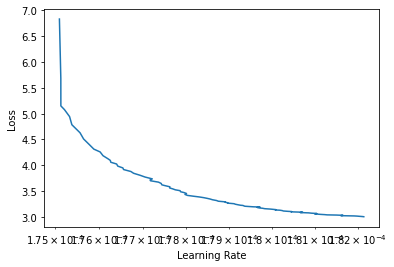

In [ ]:
#hide
learn.lr_find()

In [ ]:
learn.fit(3, cbs=WandbCallback(log_model=False, log_preds=False))

epoch,train_loss,valid_loss,accuracy,perplexity,bpc,time
0,1.431034,1.376386,0.595464,3.960561,0.954038,1:08:40


Buffered data was truncated after reaching the output size limit.

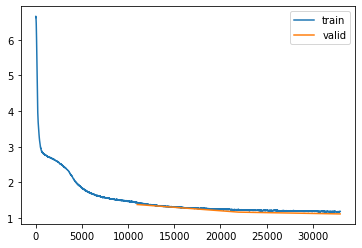

In [ ]:
learn.recorder.plot_loss()